# Time Series Anomaly Detection

* Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

**Bonus:**

* Can you label students who are viewing both the web dev and data science curriculum?
* Can you label students by the program they are in? Can you label users by student vs. staff? 
* What are Zach, Maggie, David, and Ryan's ids?

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
def wrangle_access_logs():
    # acquire
    colnames=['date', "time", 'destination', 'unknown_1',
              'unknown_2', "ip"]
    df_orig = pd.read_csv("curriculum-access.txt",          
                     engine='python',
                     header=None,
                     index_col=False,
                     names=colnames,
                     sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                     na_values='"-"',
                         )
    
    # join the date and time
    df_orig["time_stamp"] = pd.to_datetime(df_orig.date + " " + df_orig.time)
    
    # Drop columns since it is all in the time_stamp
    df_orig.drop(columns=["time", "date"], inplace = True)
    
    # Sort values by date
    df = df_orig.sort_values(by="time_stamp")
    
    # Change value types
    df["unknown_2"] = df["unknown_2"].astype(float)
    
    # Rename the unknown columns
    df = df.rename(columns={"unknown_1": "user_id", "unknown_2": "cohort"})
    
    # Set the index to date
    df = df.set_index("time_stamp")
    
    # Create new columns detailing if student is web_dev or data_science
    web_dev = df[df.destination == "java-ii"].groupby("user_id").user_id.sum().index

    df['is_wd'] = df['user_id'].apply(lambda x: 1 if x in web_dev else 0)

    ds = df[df.destination == "1-fundamentals/1.1-intro-to-data-science"].groupby("user_id").user_id.sum().index

    df['is_ds'] = df['user_id'].apply(lambda x: 1 if x in ds else 0)
    
    return df

In [3]:
logs = wrangle_access_logs()

In [4]:
logs

,destination,user_id,cohort,ip,is_wd,is_ds
time_stamp,,,,,,
2018-01-26 09:55:03,/,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:02,java-ii,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62,1,1
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62,1,0
...,...,...,...,...,...,...
2020-05-15 15:01:40,java-ii/file-io,602,56.0,48.188.241.68,1,0
2020-05-15 15:01:54,9-timeseries/3-prep,582,55.0,48.135.163.38,0,1
2020-05-15 15:03:37,jquery/ajax/requests-and-responses,637,57.0,71.121.18.17,0,0


## Look at the overall access logs, and see if there are any anomalies

Text(0.5, 1.0, 'Number of destinations requested per day')

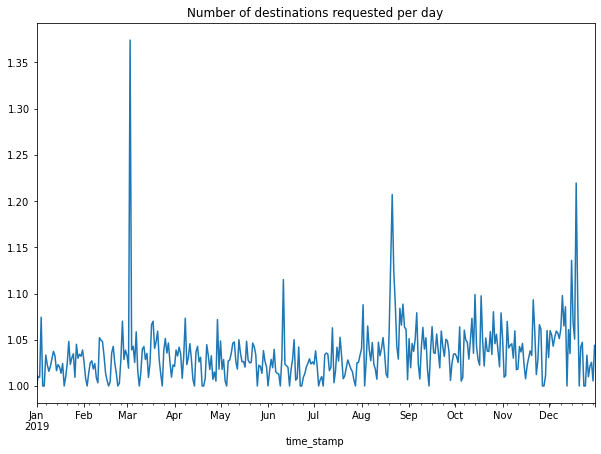

In [5]:
# Since it is a large ds, we will look at only 2019 to begin with
# We will resample the data so that it is daily
# We will measure the number of destinations per day. 

logs["2019"].groupby("time_stamp").destination.count().resample("D").mean().plot.line(figsize=(10, 7))
plt.title("Number of destinations requested per day")

In [7]:
# We will look to do a report for March 3rd, 2019. To do that - we need to look at the day before.

# df[df.destination > 1.3]

In [38]:
# We can see that our value in question is still the second to last one.
df = logs["2019-02-20":"2019-03-03"].groupby("time_stamp")[["destination"]].count().resample("D").mean()
df = df.rename(columns={"destination":"destination_count"})
df.tail()

,destination_count
time_stamp,
2019-02-27,1.028668
2019-02-28,1.038710
2019-03-01,1.033019
2019-03-02,1.019231
2019-03-03,1.374134


In [202]:
# to calculate percent - b
def create_pct_b(df, target_variable, span, bound=3):
    span = span
    ema = df.ewm(span=span, adjust=False).mean()
    stdev = df.ewm(span=span, adjust=False).std()
    
    previous_val = pd.DataFrame({'previous_val': df[target_variable]})
    prev_day_df = stdev.join(ema, how='left', lsuffix="_x")

    prev_day_df = prev_day_df.join(previous_val, how='left')

    prev_day_df.fillna(0, inplace = True)

    my_index = df.index[1:]

    prev_day_df = prev_day_df[:-1].reset_index().set_index(my_index)

    prev_day_df.drop(columns=["time_stamp", target_variable + "_x"], inplace=True)

    target_val = pd.DataFrame({'target_val': df[target_variable]})

    df = target_val.join(prev_day_df, how='left')

    df.fillna(0, inplace = True)

    df["ema"] = ema
    df["stdev"] = stdev

    # compute the upper and lower band
    df['ub'] = df['ema'] + bound*df['stdev']
    df['lb'] = df['ema'] - bound*df['stdev']

    # compute percent b
    df['pct_b'] = (df['target_val'] - df['lb']) / (df['ub'] - df['lb'])
    
    return df

In [201]:
# Test the function
df_1 = create_pct_b(df, "destination", 2)
df_1.head()

,target_val,destination,previous_val,ema,stdev,ub,lb,pct_b
time_stamp,,,,,,,,
2018-01-26,1.021429,0.000000,0.000000,1.021429,NaN,NaN,NaN,NaN
2018-01-27,1.004367,1.021429,1.021429,1.010054,0.012064,1.046248,0.973861,0.421433
2018-01-28,1.005917,1.010054,1.004367,1.007296,0.007167,1.028797,0.985795,0.467933
2018-01-29,1.012195,1.007296,1.005917,1.010562,0.005255,1.026327,0.994797,0.551791
2018-01-30,1.039872,1.010562,1.012195,1.030102,0.019776,1.089429,0.970776,0.582342


# Main Loop to Dedect Activity

In [203]:
df = logs.groupby("time_stamp")[["destination"]].count().resample("D").mean()
date = 2
active = True
while active:
    if date < df.shape[0]:
        date += 1
        df_1 = df.iloc[:date]
        df_1 = create_pct_b(df, "destination", 2)
        if df_1.pct_b[-1] > 1:
            print(f"There is an anomaly dected on: {df.index[-1]}") 
    else:
        active = False

years = ["2018", "2019", "2020"]
for col in years:
    if df_1[col].pct_b.max() < 1:
        print(f"No anomaly activity detected in {col}")
    elif df_1[col].pct_b.max() < 1:
        df_y = df_1[col]
        print(df_y[df_1.pct_b > 1].destination)

No anomaly activity detected in 2018
No anomaly activity detected in 2019
No anomaly activity detected in 2020


No strange activity happened overall. What if we look at it by user?

In [225]:
logs.cohort = logs.cohort.astype("object")

In [234]:
df = logs.groupby(["time_stamp", "cohort"])[["destination"]].count().reset_index()

In [237]:
df.cohort = df.cohort.astype("object")

In [244]:
df.groupby("cohort")[["time_stamp", "destination"]].count()

,time_stamp,destination
cohort,,
1.0,8521,8521
2.0,90,90
4.0,4,4
5.0,1,1
6.0,71,71
7.0,449,449
8.0,1685,1685
9.0,4,4
11.0,196,196
